# Forced Flux Offset

This notebook illustrates the offset issue of forced flux.

In [2]:
import injection_utils as iu

import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
from lsst.afw.math import Warper
import lsst.afw.geom as afwGeom

from astropy.table import Table

In [23]:
! pwd

/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset


## 1. make empty calexp repo

In [18]:
# empty_calexp_2_2i is an empty calexp repo, we copy it for injection purpose
# 205 means fake mag = 20.5
# We want to inject fakes with mag = [20.5, 21, 21.5, 22]

! for (( i=205; i<=220; i=i+5 )); do cp -r ./empty_calexp_2_2i/ \
/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/gal_$i; done
print()

## 2. Data Id and Injection Position

In [6]:
# Setup data id
tract, patch, filt = 2900, '4,4', 'r'
visit, detector = 1228976, 8
calexp_id = {'visit': visit, 'detector': detector, 'filter': filt}
deepCoadd_id = {'tract': tract, 'patch': patch, 'filter': filt}

In [12]:
# a list of [x, y] pixel coordinates
injection_coord = np.load('./coord_1820.npy')

## 3. Fake Injection

In [14]:
fake_dir = './data'
fake_pattern = 'gal_{}'

In [19]:
# We want to inject fakes with mag = [20.5, 21, 21.5, 22]
for fake_mag in range(205, 225, 5):
    injected_mag = fake_mag * 0.1
    calexp_repo = os.path.join(fake_dir, fake_pattern.format(fake_mag))
    iu.inject_fakes_to_calexp(calexp_repo, calexp_id, injected_mag, injection_coord, poisson=False)
print('done')

done


## 4. Subtractin, Association, and Forced Photometry

In [22]:
# Create a dia_pipeline.sh file for subtraction, association, and forced photometry
with open(f'./dia_pipeline.sh', "w+") as file:
    file.write('#！/bin/bash\n\n')
        
    for i in range(205, 225, 5):
        line = 'imageDifferenceDriver.py /global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/gal_{} \\\n'.format(i)
        file.write(line)
        line2 = '    --output /global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/al_{} \\\n'.format(i)
        file.write(line2)
        line3 = '    --id visit=1228976 detector=8  -C diffimConfig_al-bright.py \\\n'
        file.write(line3)
        line4 = '    --clobber-config --clobber-versions --cores 4\n'
        file.write(line4) 
    file.write('\n')

    for i in range(205, 225, 5):
        line = 'associationDriver.py /global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/al_{} \\\n'.format(i)
        file.write(line)
        line2 = '    --rerun association \\\n'.format(i)
        file.write(line2)
        line3 = '    --id tract=2900 filter=r --selectId visit=1228976 --cores 4 --batch-type=smp \\\n'
        file.write(line3)
        line4 = '    --clobber-config --clobber-versions --cores 4\n'
        file.write(line4)
    file.write('\n')
        
    for i in range(205, 225, 5):
        line = 'forcedPhotCcdDiaDriver.py /global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/al_{}/rerun/association \\\n'.format(i)
        file.write(line)
        line2 = '    --rerun forced \\\n'.format(i)
        file.write(line2)
        line3 = '    --id visit=1228976 --cores 10 --clobber-config --clobber-versions \\\n'
        file.write(line3)
        line4 = "    --time 100 --batch-options='-C knl -q regular'\n"
        file.write(line4)
print()

In terminal run:
- source ./setup_subtraction.sh
- source ./dia_pipeline.sh

## 5. Analysis

In [32]:
def calibrate_instFlux(lsst_table=None, photo_calib=None, flux_type='base_PsfFlux', flux_name=None, err_name=None):
    # convert instFlux to nanojansky
    flux_nanojansky = photo_calib.instFluxToNanojansky(lsst_table, flux_type)
    lsst_astropy = lsst_table.asAstropy()
    lsst_astropy[flux_name]  = flux_nanojansky[:,0]
    lsst_astropy[err_name]  = flux_nanojansky[:,1]
    return lsst_astropy


def measure_flux(coord, mag_list, mag_range, src_repo_pattern, forced_repo_pattern, diff_id):
    # merge a diaSrc table and a Forced table, save the flux from each table to a
    # pandas dataframe
    efficiency = np.zeros(len(mag_list))
    ra_list = []
    dec_list = []
    # x, y pixel coordinates in calexp image
    x_calexp_list = []
    y_calexp_list = []
    # injected magnitude
    mag_injected_list = []
    flux_injected_list = []
    # flux in diaSrc table
    flux_src_list = []
    flux_err_src_list = []
    # flux in Forced table
    flux_forced_list = []
    flux_err_forced_list = []
    # total number of sources detected in the diaSrc table
    total_src_list = []

    for i, mag in enumerate(mag_range):
        mag_str = mag_list[i]

        src_repo = src_repo_pattern.format(mag_str)
        src_butler = Butler(src_repo)
        src_table = src_butler.get('deepDiff_diaSrc', dataId=calexp_id)
        total_src = len(src_table)
        src_calib = src_butler.get('deepDiff_differenceExp_photoCalib', dataId=diff_id)
        
        src_flux_table = calibrate_instFlux(lsst_table=src_table, photo_calib=src_calib,
                                            flux_type='base_PsfFlux', flux_name='flux_src_nanojansky',
                                            err_name='flux_err_src_nanojansky')

        flux_injected_inst = src_calib.magnitudeToInstFlux(mag)
        flux_injected_nanojansky = src_calib.instFluxToNanojansky(flux_injected_inst)
        
        forced_repo = forced_repo_pattern.format(mag_str)
        forced_butler = Butler(forced_repo)
        forced_table = forced_butler.get('deepDiff_forced_diaSrc', dataId=diff_id)
        forced_flux_table = calibrate_instFlux(lsst_table=forced_table, photo_calib=src_calib,
                                               flux_type='base_PsfFlux', flux_name='flux_forced_nanojansky',
                                               err_name='flux_err_forced_nanojansky') 

        src_pd = src_flux_table.to_pandas()
        forced_pd = forced_flux_table.to_pandas()
        # I tried to use 'id' as the key, but it returns a table with 0 entries.
        dia_joint_table = pd.merge(src_pd, forced_pd, on='coord_ra', how='outer',
                       suffixes=["", "_"]).drop('coord_dec_', axis=1)
        joint_table_astropy = Table.from_pandas(dia_joint_table)
        
        # diff_detected is an index set of detected sources, diff_missed is an index set of missed sources 
        # dia_list is a list of tables, they are ordered as the coord input of check_diaSrc_detecion
        # each table contains the sources detected at each coordinate
        # for more information, check ?iu.check_diaSrc_detecion
        diff_detected, diff_missed, dia_list = iu.check_diaSrc_detecion(coord, joint_table_astropy, half_width=4)
        # calculate efficiency
        efficiency[i] = len(diff_detected) / (len(diff_detected) + len(diff_missed))

        for j in range(len(dia_list)):
            if not dia_list[j]:
                continue
            ra_list.append(dia_list[j][0]['coord_ra'])
            dec_list.append(dia_list[j][0]['coord_dec'])
            x_calexp_list.append(coord[j][0])
            y_calexp_list.append(coord[j][1])

            mag_injected_list.append(mag)
            flux_injected_list.append(flux_injected_nanojansky)

            flux_src_list.append(dia_list[j][0]['flux_src_nanojansky'])
            flux_err_src_list.append(dia_list[j][0]['flux_err_src_nanojansky'])
            flux_forced_list.append(dia_list[j][0]['flux_forced_nanojansky'])
            flux_err_forced_list.append(dia_list[j][0]['flux_err_forced_nanojansky'])
            total_src_list.append(total_src)
    results = pd.DataFrame({'ra': ra_list, 'dec': dec_list, 'x_calexp': x_calexp_list, 'y_calexp': y_calexp_list,
                            'mag_injected': mag_injected_list, 'flux_injected': flux_injected_list,
                            'flux_src': flux_src_list, 'flux_err_src': flux_err_src_list,
                            'flux_forced': flux_forced_list, 'flux_err_forced': flux_err_forced_list,
                            'tot_src': total_src_list})
    return results, efficiency

In [3]:
?iu.check_diaSrc_detecion

Signature: iu.check_diaSrc_detecion(check_coords, src_table, half_width=4)
Docstring:
This function checks whether dia sources have been detected at the coordinates given
by the check_coords.
check_coords:      A list of [x, y] pixel coordinates
src_table:         An astropy table of dia sources(diaSrc)
half_width:        The half length of the search width. The total searching region is 
                   x - half_width: x + half_width, y - half_width, y + half_width
Returns:
detected_set:      A set of diaSrc indexes(ordered as the src_table) of the detected sources
missed_set:        A set of diaSrc indexes(ordered as the src_table) of the missed sources
dia_list:          A list of astropy tables. The first dimension corresponds to the indexes
                   given from the check_coords. The second dimension collects the diaSrc table
                   of the matched sources. If a source is missed, it corresponds to an empty list.
                   e.g. [[diaSrc_0], [], [diaSr

In [26]:
mag_list = ['205','210','215','220']
mag_range = np.arange(20.5, 22.5, 0.5)
src_repo_pattern = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/al_{}'
forced_repo_pattern = '/global/cfs/cdirs/desc-sn/dia/data/shl159/fake_injection/flux_offset/data/al_{}/rerun/association/rerun/forced'
results, efficiency = measure_flux(coord=injection_coord, mag_list=mag_list, mag_range=mag_range,
                                   src_repo_pattern=src_repo_pattern, forced_repo_pattern=forced_repo_pattern,
                                   diff_id=calexp_id)
results.to_csv('results.csv', index=False)
np.save('./efficiency.npy', efficiency)

In [27]:
results = pd.read_csv('./results.csv')
efficiency = np.load('./efficiency.npy')

## 6. Plots

In [28]:
def plot_residual(ax, flux1, flux2, xlabel, ylabel, title):
    residual = (flux2 - flux1) / flux1
    ax.scatter(flux1, residual, marker='.')
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    ax.hlines(y=0, xmin=xlims[0], xmax=xlims[1], color='gray')
    ax.set_ylim(-np.max(np.abs(ylims)), np.max(np.abs(ylims)))
    ax.set_xlabel(xlabel, size=15)
    ax.set_ylabel(ylabel, size=15)
    ax.set_title(title, size=15) 
    
def show_residual(results, fake_mag_range, host_mag_range):
    fig, ax = plt.subplots(1, 3, figsize=((25, 6)))
    plot_residual(ax[0], results['flux_src'], results['flux_forced'],
                  'flux: diaSrc (nJy)', '(flux_Forced - flux_diaSrc) / flux_diaSrc',
                  'forced vs. src, fake {}, host {}'.format(fake_mag_range, host_mag_range))
    plot_residual(ax[1], results['flux_injected'], results['flux_forced'],
                  'flux: injected (nJy)', '(flux_Forced - flux_injected) / flux_injected',
                  'forced vs. injected, fake {}, host {}'.format(fake_mag_range, host_mag_range))
    plot_residual(ax[2], results['flux_injected'], results['flux_src'],
                  'flux: injected (nJy)', '(flux_src - flux_injected) / flux_injected',
                  'diaSrc vs. injected, fake {}, host {}'.format(fake_mag_range, host_mag_range))

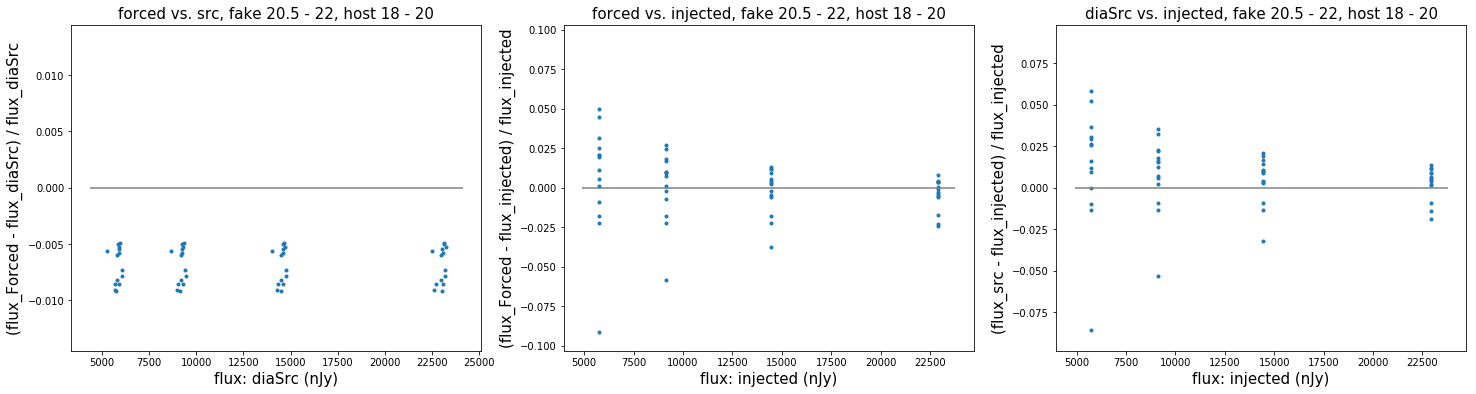

In [31]:
show_residual(results, host_mag_range='18 - 20', fake_mag_range='20.5 - 22')